In [1]:
write = True # log this version as new
MODEL_DESCRIPTION = "Stratified Learning"

In [2]:
import os
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sys import stdout
from datetime import datetime
import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback
from astropy.io import fits
import random
from DataMaker import HDF5ImageGenerator

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from tensorflow.keras.layers import Cropping2D, ZeroPadding2D, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape
import tensorflow_probability as tfp
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tensorflow.nn import leaky_relu
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

In [4]:
LATENT_DIM = 256
BASE_DEPTH = 8
IMAGE_SHAPE = (5, 127, 127)
BATCH_SIZE = 512
EPOCHS = 250
CHECKPOINTS_TO_SAVE = 4
KL_WEIGHT = 1e-6
# Good value: 1e-6
# With KL 0 val_loss = 0.4763
# With KL 1e-6 val loss = 1.0732
# With KL 1e-8 val loss = 0.5257
# With KL 1e-10 val loss = 0.4466 0.4291

In [5]:
gpus = tf.config.list_physical_devices('GPU');
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)]);
        logical_gpus = tf.config.experimental.list_logical_devices('GPU');
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

2023-04-09 22:53:09.558021: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


1 Physical GPUs, 1 Logical GPUs


2023-04-09 22:53:09.580336: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-09 22:53:09.581418: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-09 22:53:09.583741: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-09 22:53:09.585540: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [6]:
now = datetime.now()

DATASET_NAME = "HSC_v6"
MODEL_TYPE = "CVAE"
MODEL_VERSION = "v1.0"
MODEL_SUBVERSION = "v1.0." + now.strftime("%Y%m%d_%H_%M_%S")

model_id = '_'.join([DATASET_NAME, MODEL_TYPE, MODEL_VERSION])
model_path = os.path.join('/models', model_id, MODEL_SUBVERSION, 'model')
checkpoints_path = os.path.join('/models', model_id, MODEL_SUBVERSION, 'checkpoints')
logs_path = os.path.join('/logs', model_id, MODEL_SUBVERSION)
predictions_path = os.path.join('/predictions', model_id, MODEL_SUBVERSION)
weights_path = model_path + '/weights.h5'

os.makedirs(model_path, exist_ok = True)
os.makedirs(checkpoints_path, exist_ok = True)
os.makedirs(logs_path, exist_ok = True)
os.makedirs(predictions_path, exist_ok = True)

if write == True:
    with open("/models/README.md", "a") as myfile:
        myfile.write(MODEL_TYPE + " " + MODEL_SUBVERSION + " - " + MODEL_DESCRIPTION + " - B. Li" + "\n")
else:
    with open("/models/README.md", "a") as myfile:
        myfile.write(MODEL_TYPE + " " + MODEL_SUBVERSION + " - ... "+ " - B. Li" + "\n")

In [7]:
args_gen = {'X_key': 'image',
    'y_key': 'specz_redshift',
    'scaler': False,
    'labels_encoding': False,
    'batch_size': BATCH_SIZE,
    'mode': 'train',
    'shuffle': False}

train_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step2A/127x127/5x127x127_training.hdf5', **args_gen)
val_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step2A/127x127/5x127x127_validation.hdf5', **args_gen)
test_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step2A/127x127/5x127x127_testing.hdf5', **args_gen)

In [8]:
n = BATCH_SIZE
l = len(train_gen._indices)

In [9]:
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(LATENT_DIM), scale = 0.1), reinterpreted_batch_ndims = 1)

images = Input(shape = IMAGE_SHAPE)
redshifts = Input(shape = 1,)
conv1 = Conv2D(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
            padding = 'same', data_format = 'channels_first')(images)
conv2 = Conv2D(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
            padding = 'same', data_format = 'channels_first')(conv1)
flatten1 = Flatten()(conv2)
dense1 = Dense(1024, activation = None)(flatten1)
dense2 = tf.keras.layers.Dense(128, activation = "relu")(redshifts)
reshape = tf.keras.layers.Reshape((2, 8, 8))(dense2)
conv3 = Conv2DTranspose(1, 1, strides = 1, activation = leaky_relu, 
                    padding = 'same', data_format = 'channels_first')(reshape)
conv4 = Conv2DTranspose(1, 1, strides = 1, activation = leaky_relu, 
                    padding = 'same', data_format = 'channels_first')(conv3)
flatten2 = Flatten()(conv4)
dense3 = tf.keras.layers.Dense(1024, activation = "relu")(flatten2)
concat = tf.keras.layers.Concatenate()([dense1, dense3])
dense4 = Dense(tfpl.MultivariateNormalTriL.params_size(LATENT_DIM), activation = None)(concat)
z = tfpl.MultivariateNormalTriL(LATENT_DIM,
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight = KL_WEIGHT))(dense4)
encoder = Model([images, redshifts], z)

zc = tf.keras.layers.Concatenate()([z, redshifts])

In [10]:
dense5 = Dense(8 * LATENT_DIM * 32 * 32, activation = None)
reshape = Reshape((8 * LATENT_DIM, 32, 32))
conv5 = Conv2DTranspose(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
                    padding = 'same', data_format = 'channels_first')
conv6 = Conv2DTranspose(BASE_DEPTH, 3, strides = 2, activation = leaky_relu,
                    padding = 'same', data_format = 'channels_first')
conv7 = Conv2DTranspose(BASE_DEPTH, 3, strides = 1, activation = leaky_relu, 
                    padding = 'same', data_format = 'channels_first')
conv8 = Conv2D(IMAGE_SHAPE[0], 3, strides = 1, activation = None, 
           padding = 'same', data_format = 'channels_first')
cropping = Cropping2D(cropping=((0, 1), (0, 1)), data_format = 'channels_first')
outputs = Reshape(IMAGE_SHAPE)

In [11]:
dense5_model = dense5(zc)
reshape_model = reshape(dense5_model)
conv5_model = conv5(reshape_model)
conv6_model = conv6(conv5_model)
conv7_model = conv7(conv6_model)
conv8_model = conv8(conv7_model)
cropping_model = cropping(conv8_model)
outputs_model = outputs(cropping_model)

In [12]:
model = Model(inputs = [images, redshifts], outputs = [outputs_model])

In [13]:
latents = Input(shape = (LATENT_DIM + 1, ))
dense5_decoder = dense5(latents)
reshape_decoder = reshape(dense5_decoder)
conv5_decoder = conv5(reshape_decoder)
conv6_decoder = conv6(conv5_decoder)
conv7_decoder = conv7(conv6_decoder)
conv8_decoder = conv8(conv7_decoder)
cropping_decoder = cropping(conv8_decoder)
outputs_decoder = outputs(cropping_decoder)

In [14]:
decoder = Model(latents, outputs_decoder)

In [15]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 128)          256         ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 5, 127, 127  0           []                               
                                )]                                                                
                                                                                                  
 reshape (Reshape)              (None, 2, 8, 8)      0           ['dense_1[0][0]']          

In [16]:
optimizer = Adam(lr = 0.0001)
model.compile(optimizer = optimizer, loss = 'mse')

/home/billyli/miniconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
run = neptune.init_run(
    name = MODEL_SUBVERSION,
    project = "astro-data-lab/VAE",
    api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxOGFlZGMxOC04MWU5LTQ2NDctYjlhZS05NGE2NGQ0NmIzMmEifQ==",
)  # your credentials

# logs_callback = TensorBoard(log_dir = logs_path)

weights_callback = ModelCheckpoint(filepath = os.path.join(checkpoints_path, 'weights_epoch{epoch}.hdf5'), save_freq = int(EPOCHS/CHECKPOINTS_TO_SAVE), save_weights_only = True)

LR_callback = ReduceLROnPlateau()

def scheduler(epoch, lr):
    if epoch <= 100:
        return lr
    else:
        return lr / 10

LR_modify_callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose = 0)

# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs_path, histogram_freq = 1)

neptune_callback = NeptuneCallback(run = run)

https://app.neptune.ai/astro-data-lab/VAE/e/VAE-128


Info (NVML): RM has detected an NVML/RM version mismatch.. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/help/nvml_error/


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


train_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step2A/127x127/5x127x127_training.hdf5', **args_gen)

history = model.fit(train_gen, epochs = 50, callbacks = [neptune_callback], validation_data = val_gen, verbose = 1)

train_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step3/5x127x127_training_min_3.hdf5', **args_gen)

history = model.fit(train_gen, epochs = 75, callbacks = [neptune_callback], validation_data = val_gen, verbose = 1)

In [18]:
# train_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step3/5x127x127_training_min_2.hdf5', **args_gen)

In [19]:
# history = model.fit(train_gen, epochs = 100, callbacks = [weights_callback, neptune_callback], validation_data = val_gen, verbose = 1)

In [20]:
# train_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step3/5x127x127_training_min_1.hdf5', **args_gen)

In [21]:
# history = model.fit(train_gen, epochs = 100, callbacks = [weights_callback, neptune_callback], validation_data = val_gen, verbose = 1)

In [22]:
train_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step2A/127x127/5x127x127_training.hdf5', **args_gen)

In [23]:
history = model.fit(train_gen, epochs = 200, callbacks = [neptune_callback, LR_callback], validation_data = val_gen, verbose = 1)

Epoch 1/200


2023-04-09 22:53:20.093936: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-09 22:55:22.418760: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2023-04-09 22:59:27.190945: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-09 23:00:06.717467: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-09 23:00:06.717490: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be pri

392/392 [==============================] - 1074s 2s/step - loss: 2.8742 - val_loss: 2.3316 - lr: 1.0000e-04
Epoch 2/200
392/392 [==============================] - 693s 2s/step - loss: 2.3751 - val_loss: 2.2305 - lr: 1.0000e-04
Epoch 3/200
392/392 [==============================] - 716s 2s/step - loss: 2.6138 - val_loss: 2.2787 - lr: 1.0000e-04
Epoch 4/200
392/392 [==============================] - 700s 2s/step - loss: 2.4870 - val_loss: 2.3506 - lr: 1.0000e-04
Epoch 5/200
392/392 [==============================] - 770s 2s/step - loss: 2.4209 - val_loss: 2.2213 - lr: 1.0000e-04
Epoch 6/200
392/392 [==============================] - 907s 2s/step - loss: 2.5165 - val_loss: 2.2763 - lr: 1.0000e-04
Epoch 7/200
392/392 [==============================] - 835s 2s/step - loss: 2.4736 - val_loss: 2.3309 - lr: 1.0000e-04
Epoch 8/200
392/392 [==============================] - 833s 2s/step - loss: 2.4043 - val_loss: 2.1697 - lr: 1.0000e-04
Epoch 9/200
392/392 [==============================] - 847s

KeyboardInterrupt: 

In [24]:
model.save_weights(weights_path)

2023-04-11 16:53:32.757381: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2155872256 exceeds 10% of free system memory.


In [25]:
model.load_weights(weights_path)

2023-04-11 16:54:10.559938: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2155872256 exceeds 10% of free system memory.


z = 0.085649997


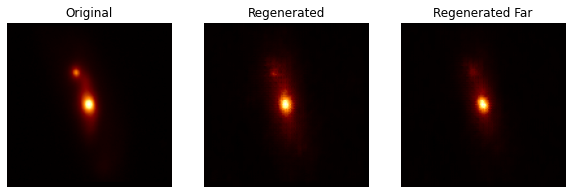

In [26]:
lib = 3
index = 466
z = test_gen[lib][0][1][index]
z_shifted = 4
band = 0
print(f'z = {z}')
str = np.asarray(encoder([np.array([test_gen[lib][0][0][index]]), np.array([test_gen[lib][0][1][index]])])[0])
str = np.concatenate((str, np.array([z])))
str = str.reshape(1, LATENT_DIM + 1)
str_shifted = np.asarray(encoder([np.array([test_gen[lib][0][0][index]]), np.array([test_gen[lib][0][1][index]])])[0])
str_shifted = np.concatenate((str_shifted, np.array([z_shifted])))
str_shifted = str_shifted.reshape(1, LATENT_DIM + 1)
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 5))
axes[0].imshow(test_gen[lib][0][0][index][band], cmap = 'afmhot')
axes[1].imshow(decoder([str])[0][band], cmap = 'afmhot')
axes[2].imshow(decoder([str_shifted])[0][band], cmap = 'afmhot')
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[0].set_title("Original")
axes[1].set_title("Regenerated")
axes[2].set_title("Regenerated Far")
plt.show()

z = 3.83520007


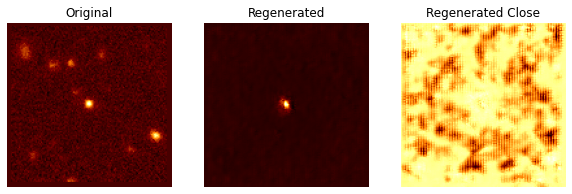

In [27]:
lib = 5
index = 271
z = test_gen[lib][0][1][index]
z_shifted = 1
band = 0
print(f'z = {z}')
str = np.asarray(encoder([np.array([test_gen[lib][0][0][index]]), np.array([test_gen[lib][0][1][index]])])[0])
str = np.concatenate((str, np.array([z])))
str = str.reshape(1, LATENT_DIM + 1)
str_shifted = np.asarray(encoder([np.array([test_gen[lib][0][0][index]]), np.array([test_gen[lib][0][1][index]])])[0])
str_shifted = np.concatenate((str_shifted, np.array([z_shifted])))
str_shifted = str_shifted.reshape(1, LATENT_DIM + 1)
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 5))
axes[0].imshow(test_gen[lib][0][0][index][band], cmap = 'afmhot')
axes[1].imshow(decoder([str])[0][band], cmap = 'afmhot')
axes[2].imshow(decoder([str_shifted])[0][band], cmap = 'afmhot')
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[0].set_title("Original")
axes[1].set_title("Regenerated")
axes[2].set_title("Regenerated Close")
plt.show()

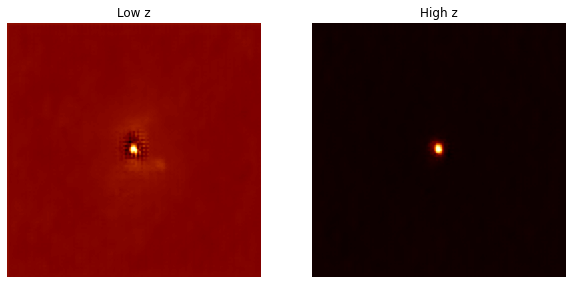

In [28]:
band = 0
str = prior.sample(1)[0]
strlo = np.concatenate((str, np.array([0.1])))
strlo = strlo.reshape(1, LATENT_DIM + 1)
strhi = np.concatenate((str, np.array([4])))
strhi = strhi.reshape(1, LATENT_DIM + 1)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
axes[0].imshow(decoder([strlo])[0][band], cmap = 'afmhot')
axes[1].imshow(decoder([strhi])[0][band], cmap = 'afmhot')
axes[0].axis('off')
axes[1].axis('off')
axes[0].set_title("Low z")
axes[1].set_title("High z")
plt.show()

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
x_array = np.arange(5)
lo_array = np.array([])
hi_array = np.array([])
for j in range(0, 5):
    lo_array = np.append(lo_array, decoder([strlo])[0][j][63][63])
    hi_array = np.append(hi_array, decoder([strhi])[0][j][63][63])
axes[0].scatter(x_array, lo_array, c = 'blue', label = 'Low')
axes[1].scatter(x_array, hi_array, c = 'red', label = 'High')
axes[0].set_xlabel("Bands")
axes[0].set_ylabel("Central Pixel Value")
axes[0].legend()
axes[1].legend()

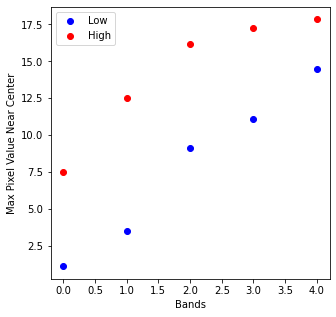

In [29]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
x_array = np.arange(5)
lo_array = np.array([])
hi_array = np.array([])
for j in range(0, 5):
    lo_array = np.append(lo_array, np.amax(np.transpose(np.asarray(decoder([strlo])[0][j][60:67]))[60:67].flatten()))
    hi_array = np.append(hi_array, np.amax(np.transpose(np.asarray(decoder([strhi])[0][j][60:67]))[60:67].flatten()))
axes.scatter(x_array, lo_array, c = 'blue', label = 'Low')
axes.scatter(x_array, hi_array, c = 'red', label = 'High')
axes.set_xlabel("Bands")
axes.set_ylabel("Max Pixel Value Near Center")
axes.legend()
axes.legend()

In [30]:
for j in range(3, 80):
    for i in range(0, 512):
        if test_gen[j][0][1][i] <= 0.1:
            print(j)
            print(i)

3
267
3
461
3
466
4
28
4
135
4
158
4
179
5
209
5
361
5
449
6
13
6
274
6
497
7
222
7
438
8
43
8
487
8
498
9
93
9
278
9
337
9
474
10
311
10
423
11
70
11
80
11
82
11
83
11
323
11
349
11
458
11
462
12
5
12
107
12
118
12
130
12
132
12
150
12
152
12
157
12
162
12
167
12
171
12
190
12
197
12
210
12
231
12
254
12
255
12
257
12
261
12
264
12
270
12
284
12
287
12
294
12
295
12
297
12
298
12
299
12
300
12
304
12
307
12
308
12
314
12
318
12
319
12
343
12
348
12
351
12
360
12
365
12
366
12
405
12
408
12
412
12
417
12
421
12
431
12
433
12
453
12
461
12
480
12
503
13
9
13
10
13
12
13
17
13
18
13
39
13
44
13
58
13
59
13
64
13
66
13
98
13
101
13
112
13
115
13
117
13
118
13
123
13
136
13
140
13
148
13
149
13
175
13
177
13
189
13
214
13
220
13
224
13
245
13
269
13
276
13
281
13
288
13
293
13
297
13
300
13
302
13
310
13
319
13
325
13
340
13
356
13
366
13
372
13
374
13
379
13
416
13
421
13
449
13
453
13
481
13
485
13
506
14
7
14
41
14
57
14
77
14
97
14
121
14
155
14
185
14
210
14
217
14
221
14
222
14
224
1

KeyboardInterrupt: 

In [ ]:
for j in range(3, 80):
    for i in range(0, 512):
        if test_gen[j][0][1][i] >= 3.5:
            print(j)
            print(i)

In [31]:
for i in range(0, 84):
    l = 512
    if i == 83:
        l = 464
    for j in range(0, l):
        index = i * BATCH_SIZE + j + 1
        stdout.write("\rChecking %d samples of " % (index) + "42960")
        z = test_gen[i][0][1][j]
        str = np.asarray(encoder([np.array([test_gen[i][0][0][j]]), np.array([test_gen[i][0][1][j]])])[0])
        str = np.concatenate((str, np.array([z])))
        str = str.reshape(1, LATENT_DIM + 1)
        hdul = fits.PrimaryHDU(data = test_gen[i][0][0][j])
        string = f"/data/CVAE Generated/Full/Original Galaxy #{index}.fits"
        hdul.writeto(string, overwrite = True)
        hdul = fits.PrimaryHDU(data = decoder([str])[0])
        string = f"/data/CVAE Generated/Full/Reconstructed Galaxy #{index}.fits"
        hdul.writeto(string, overwrite = True)

Checking 9405 samples of 42960

KeyboardInterrupt: 

In [32]:
def scatter_bands_max_near_center(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show / 5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_array = np.append(true_array, np.amax(np.array([test_gen[0][0][0][i][j]])))
            pred_array = np.append(pred_array, np.amax(np.transpose(np.asarray(model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j][60:67]))[60:67].flatten()))
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_xlabel("Bands")
        axes[int((i - index) / 5)][int((i - index) % 5)].set_ylabel(f"Maximum normalized pixel value z = {np.array([test_gen[0][0][1][i]])[0]}")
        axes[int((i - index) / 5)][int((i - index) % 5)].legend()

def scatter_bands_max(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show / 5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_array = np.append(true_array, np.amax(np.array([test_gen[0][0][0][i][j]])))
            pred_array = np.append(pred_array, np.amax(np.array([model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j]])))
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_xlabel("Bands")
        axes[int((i - index) / 5)][int((i - index) % 5)].set_ylabel("Maximum normalized pixel value")
        axes[int((i - index) / 5)][int((i - index) % 5)].legend()
        
def scatter_bands_center(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show / 5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_array = np.append(true_array, np.array([test_gen[0][0][0][i][j]])[0][63][63])
            pred_array = np.append(pred_array, model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j][63][63])
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_xlabel("Bands")
        axes[int((i - index) / 5)][int((i - index) % 5)].set_ylabel(f"Central pixel value z = {np.array([test_gen[0][0][1][i]])}")
        axes[int((i - index) / 5)][int((i - index) % 5)].legend()
        
def scatter_bands_center_shift(lib = 3, i = 37, z = 1):
    print(z)
    fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
    x_array = np.arange(5)
    true_array = np.array([])
    pred_array = np.array([])
    for j in range(0, 5):
        true_array = np.append(true_array, np.array([test_gen[lib][0][0][i][j]])[0][63][63])
        pred_array = np.append(pred_array, model([np.array([test_gen[lib][0][0][i]]), np.array([z])])[0][j][63][63])
    axes.scatter(x_array, true_array, c = 'blue', label = 'True')
    axes.scatter(x_array, pred_array, c = 'red', label = 'Predicted')
    axes.set_xlabel("Bands")
    axes.set_ylabel("Central pixel value")
    axes.legend()
    
def scatter_bands_max_shift(lib = 3, i = 37, z = 1):
    print(z)
    fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
    x_array = np.arange(5)
    true_array = np.array([])
    pred_array = np.array([])
    for j in range(0, 5):
        true_array = np.append(true_array, np.amax(np.array([test_gen[lib][0][0][i][j]])))
        pred_array = np.append(pred_array, np.amax(np.array([model([np.array([test_gen[lib][0][0][i]]), np.array([z])])[0][j]])))
    axes.scatter(x_array, true_array, c = 'blue', label = 'True')
    axes.scatter(x_array, pred_array, c = 'red', label = 'Predicted')
    axes.set_xlabel("Bands")
    axes.set_ylabel("Central pixel value")
    axes.legend()

def scatter_bands_percentile(percentile = 90, num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show /  5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_90 = np.percentile(np.array([test_gen[0][0][0][i][j]]).flatten(), percentile)
            pred_90 = np.percentile(np.asarray(model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j]).flatten(), percentile)
            true_array = np.append(true_array, true_90)
            pred_array = np.append(pred_array, pred_90)
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_xlabel('Bands')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_ylabel(f'{percentile}th percentile normalized pixel value')
        axes[int((i - index) / 5)][int((i - index) % 5)].legend()

def scatter_bands_mean(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show / 5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_mean = np.mean(np.array([test_gen[0][0][0][i][j]]).flatten())
            pred_mean = np.mean(np.asarray(model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j]).flatten())
            true_array = np.append(true_array, true_mean)
            pred_array = np.append(pred_array, pred_mean)
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_xlabel('Bands')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_ylabel('Mean normalized pixel value')
        axes[int((i - index) / 5)][int((i - index) % 5)].legend()

def display_histograms(num_to_show = 2, index = 0):
    fig, axes = plt.subplots(nrows = num_to_show, ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        for j in range(0, 5):
            true_arr = sorted(np.array([test_gen[0][0][0][i][j]]).flatten())
            pred_arr = sorted(np.asarray(model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j]).flatten())
            true_arr = true_arr[0 : int(len(true_arr) * .99)]
            pred_arr = pred_arr[0 : int(len(pred_arr) * .99)]
            axes[i][j].hist(true_arr, 100, color = 'blue', label = 'True', alpha = 0.5)
            axes[i][j].hist(pred_arr, 100, color = 'red', label = 'Predicted', alpha = 0.5)
            axes[i][j].set_xlabel("Pixel Values")
            axes[i][j].set_ylabel("Count")
            axes[i][j].legend()
    fig.suptitle('Histograms of Predicted vs. True Image, Horizontal are Bands')
    
def display_5_bands(index):
    fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (20, 10))
    loss = round(model.evaluate([np.array([test_gen[0][0][0][index]]), np.array([test_gen[0][0][1][index]])], np.array([test_gen[0][0][0][index]]), verbose = 0), 2)
    for i in range(0, 5):
        axes[0][i].imshow(np.array([test_gen[0][0][0][index]])[0][i], cmap = 'afmhot')
        max_pixel_true = round(np.amax(np.array([test_gen[0][0][0][index]])[0][i]), 2)
        # axes[0][i].set_title(f'True band {i} max = {max_pixel_true}')
        pred = model([np.array([test_gen[0][0][0][index]]), np.array([test_gen[0][0][1][index]])])[0][i]
        axes[1][i].imshow(pred, cmap = 'afmhot')
        max_pixel_pred = round(np.amax(pred), 2)
        axes[1][i].set_title(f'\n loss = {loss}') # f'Pred band {i} max = {max_pixel_pred}' + 
        
def display_high_loss(num_to_show, min_loss):
    fig, axes = plt.subplots(nrows = num_to_show, ncols = 5, figsize = (20, 5 * num_to_show))
    r = 0
    for i in range(BATCH_SIZE):
        loss = round(model.evaluate([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])], np.array([test_gen[0][0][0][i]]), verbose = 0), 2)
        if loss >= min_loss:
            print(i)
            for j in range(0, 5):
                axes[r][j].imshow(np.array([test_gen[0][0][0][i]])[0][j], cmap = 'afmhot')
                axes[r][j].set_title(f'Loss = {loss}')
            r += 1
        if r >= num_to_show:
            break

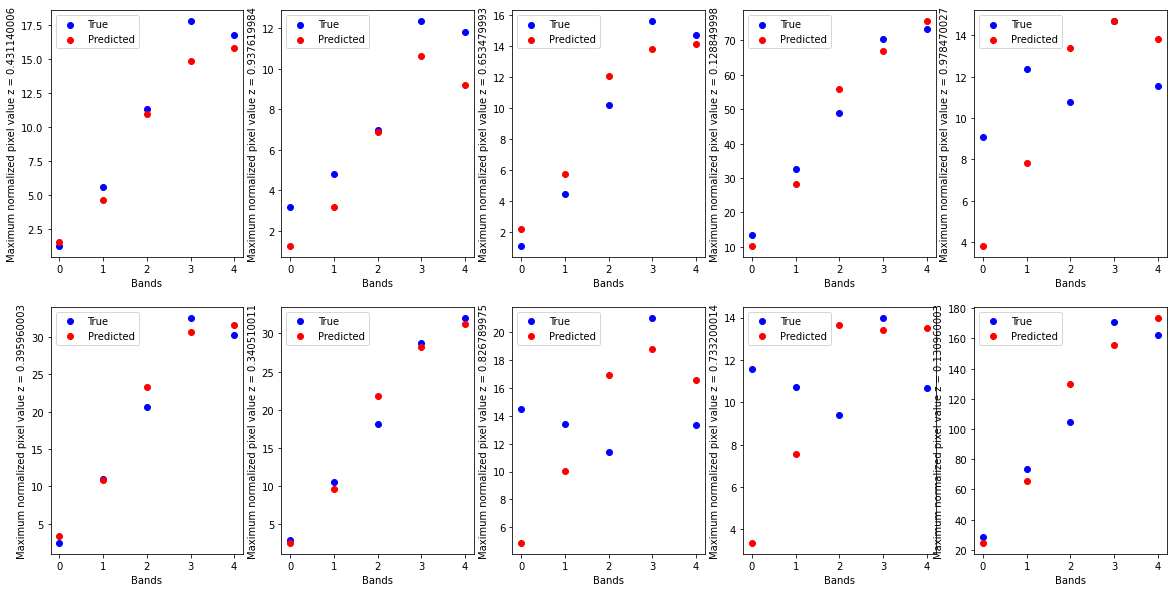

In [33]:
scatter_bands_max_near_center(num_to_show = 10, index = 10)

512
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

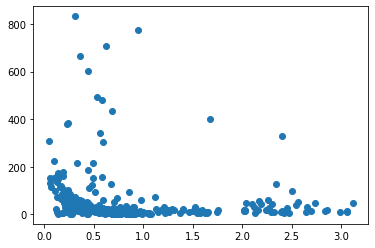

In [34]:
x_array = np.array([])
y_array = np.array([])
l = len(test_gen[0][0][0])
print(l)
for i in range(0, l):
    x_array = np.append(x_array, np.amax(np.array([test_gen[0][0][0][i][4]])))
    y_array = np.append(y_array, np.array([test_gen[0][0][1][i]])[0])
    print(i)
plt.scatter(y_array, x_array)

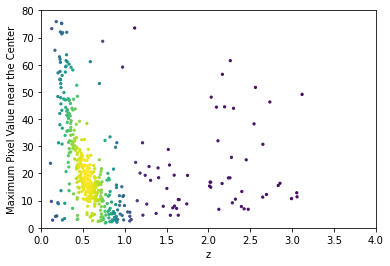

In [35]:
from scipy.stats import gaussian_kde
xy = np.asarray(np.vstack([y_array, x_array])).astype('float32')
z = gaussian_kde(xy)(xy)
plt.scatter(y_array, x_array, s = 5, c = z)
plt.xlim(0,4)
plt.ylim(0, 80)
plt.xlabel("z")
plt.ylabel("Maximum Pixel Value near the Center")
plt.show()

40


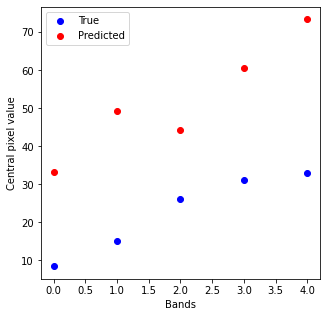

In [36]:
scatter_bands_center_shift(lib = 3, i = 267, z = 40)

3.99530005


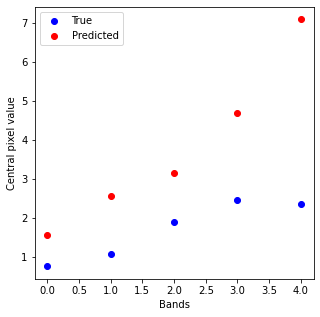

In [37]:
scatter_bands_max_shift(lib = 3, i = 37, z = test_gen[3][0][1][37])

0.1


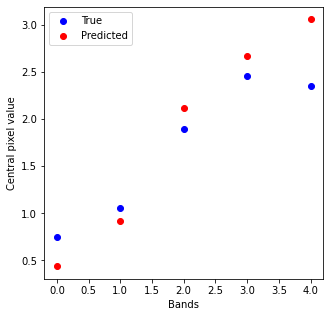

In [38]:
scatter_bands_max_shift(lib = 3, i = 37, z = 0.1)

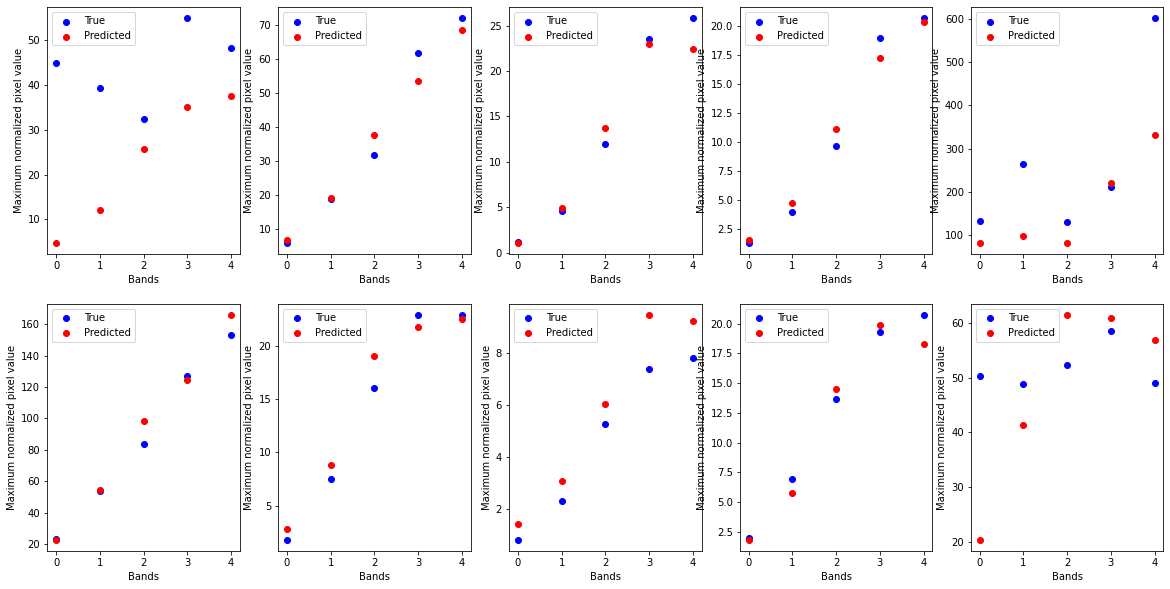

In [39]:
scatter_bands_max()

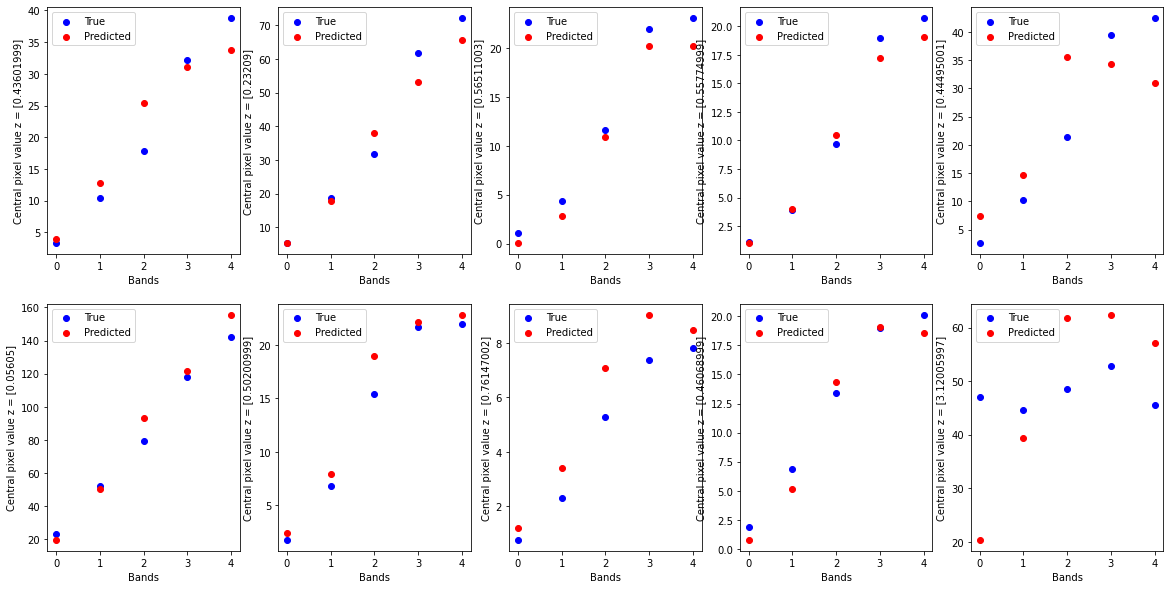

In [40]:
scatter_bands_center()

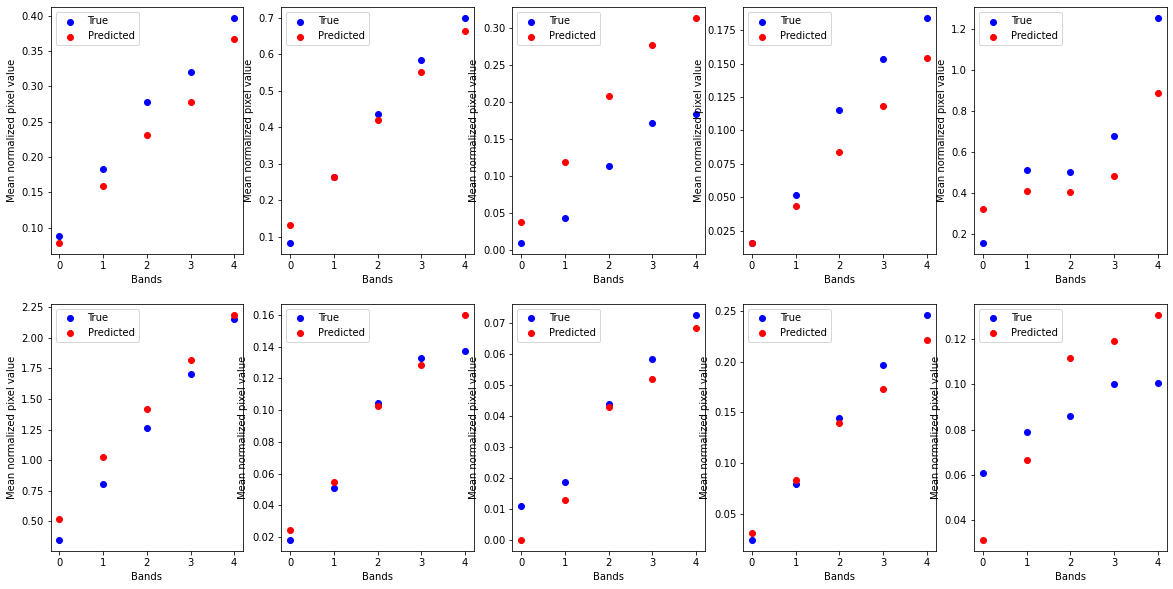

In [41]:
scatter_bands_mean(10, 0)

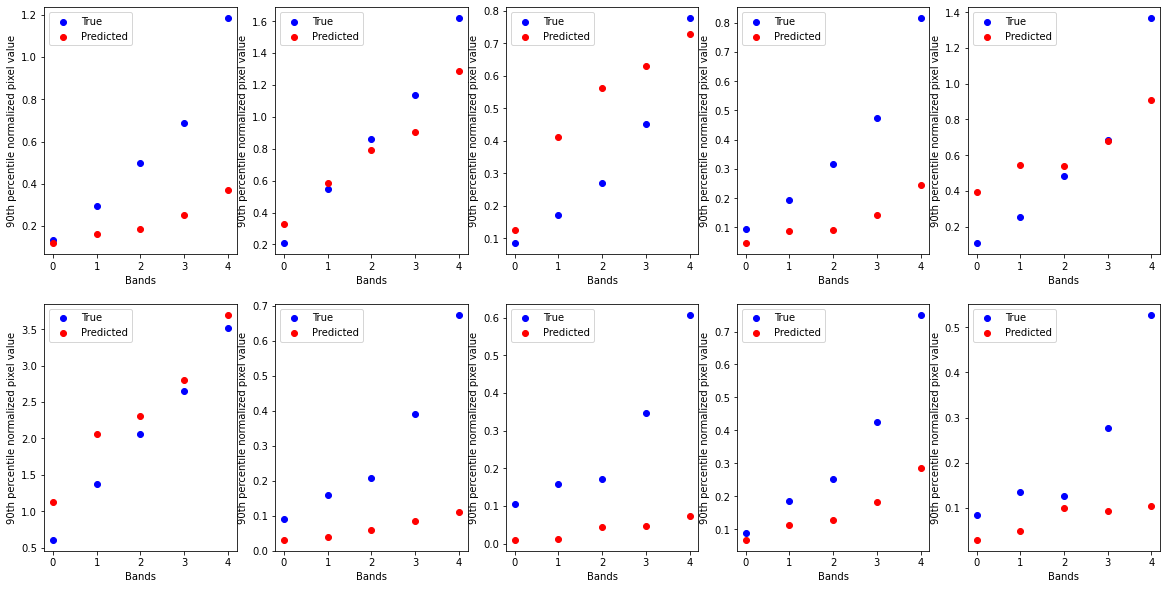

In [42]:
scatter_bands_percentile()

In [43]:
# display_histograms()

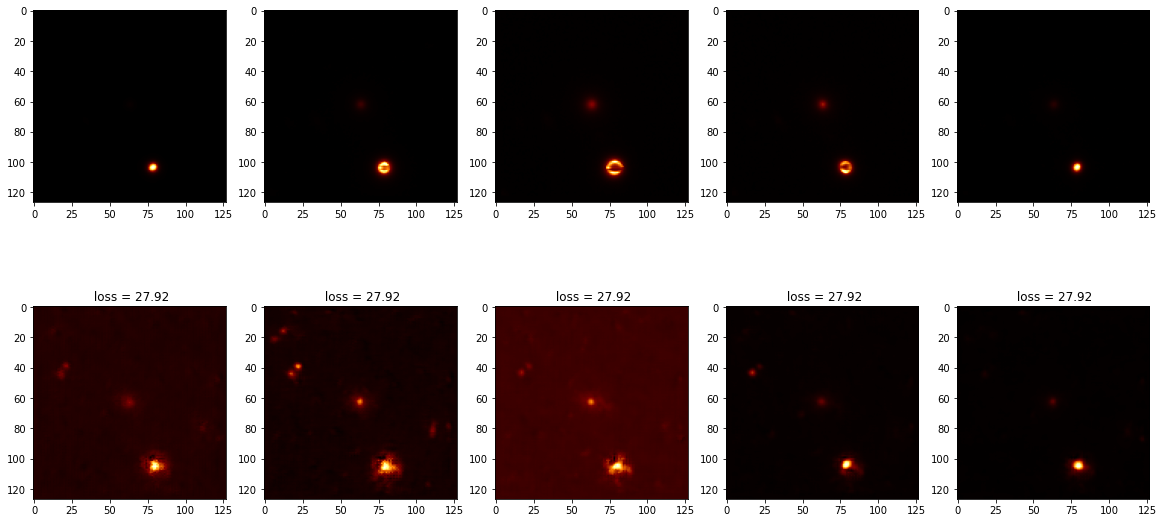

In [44]:
display_5_bands(38)

4
34
38
40
83
104
143
152
180
194


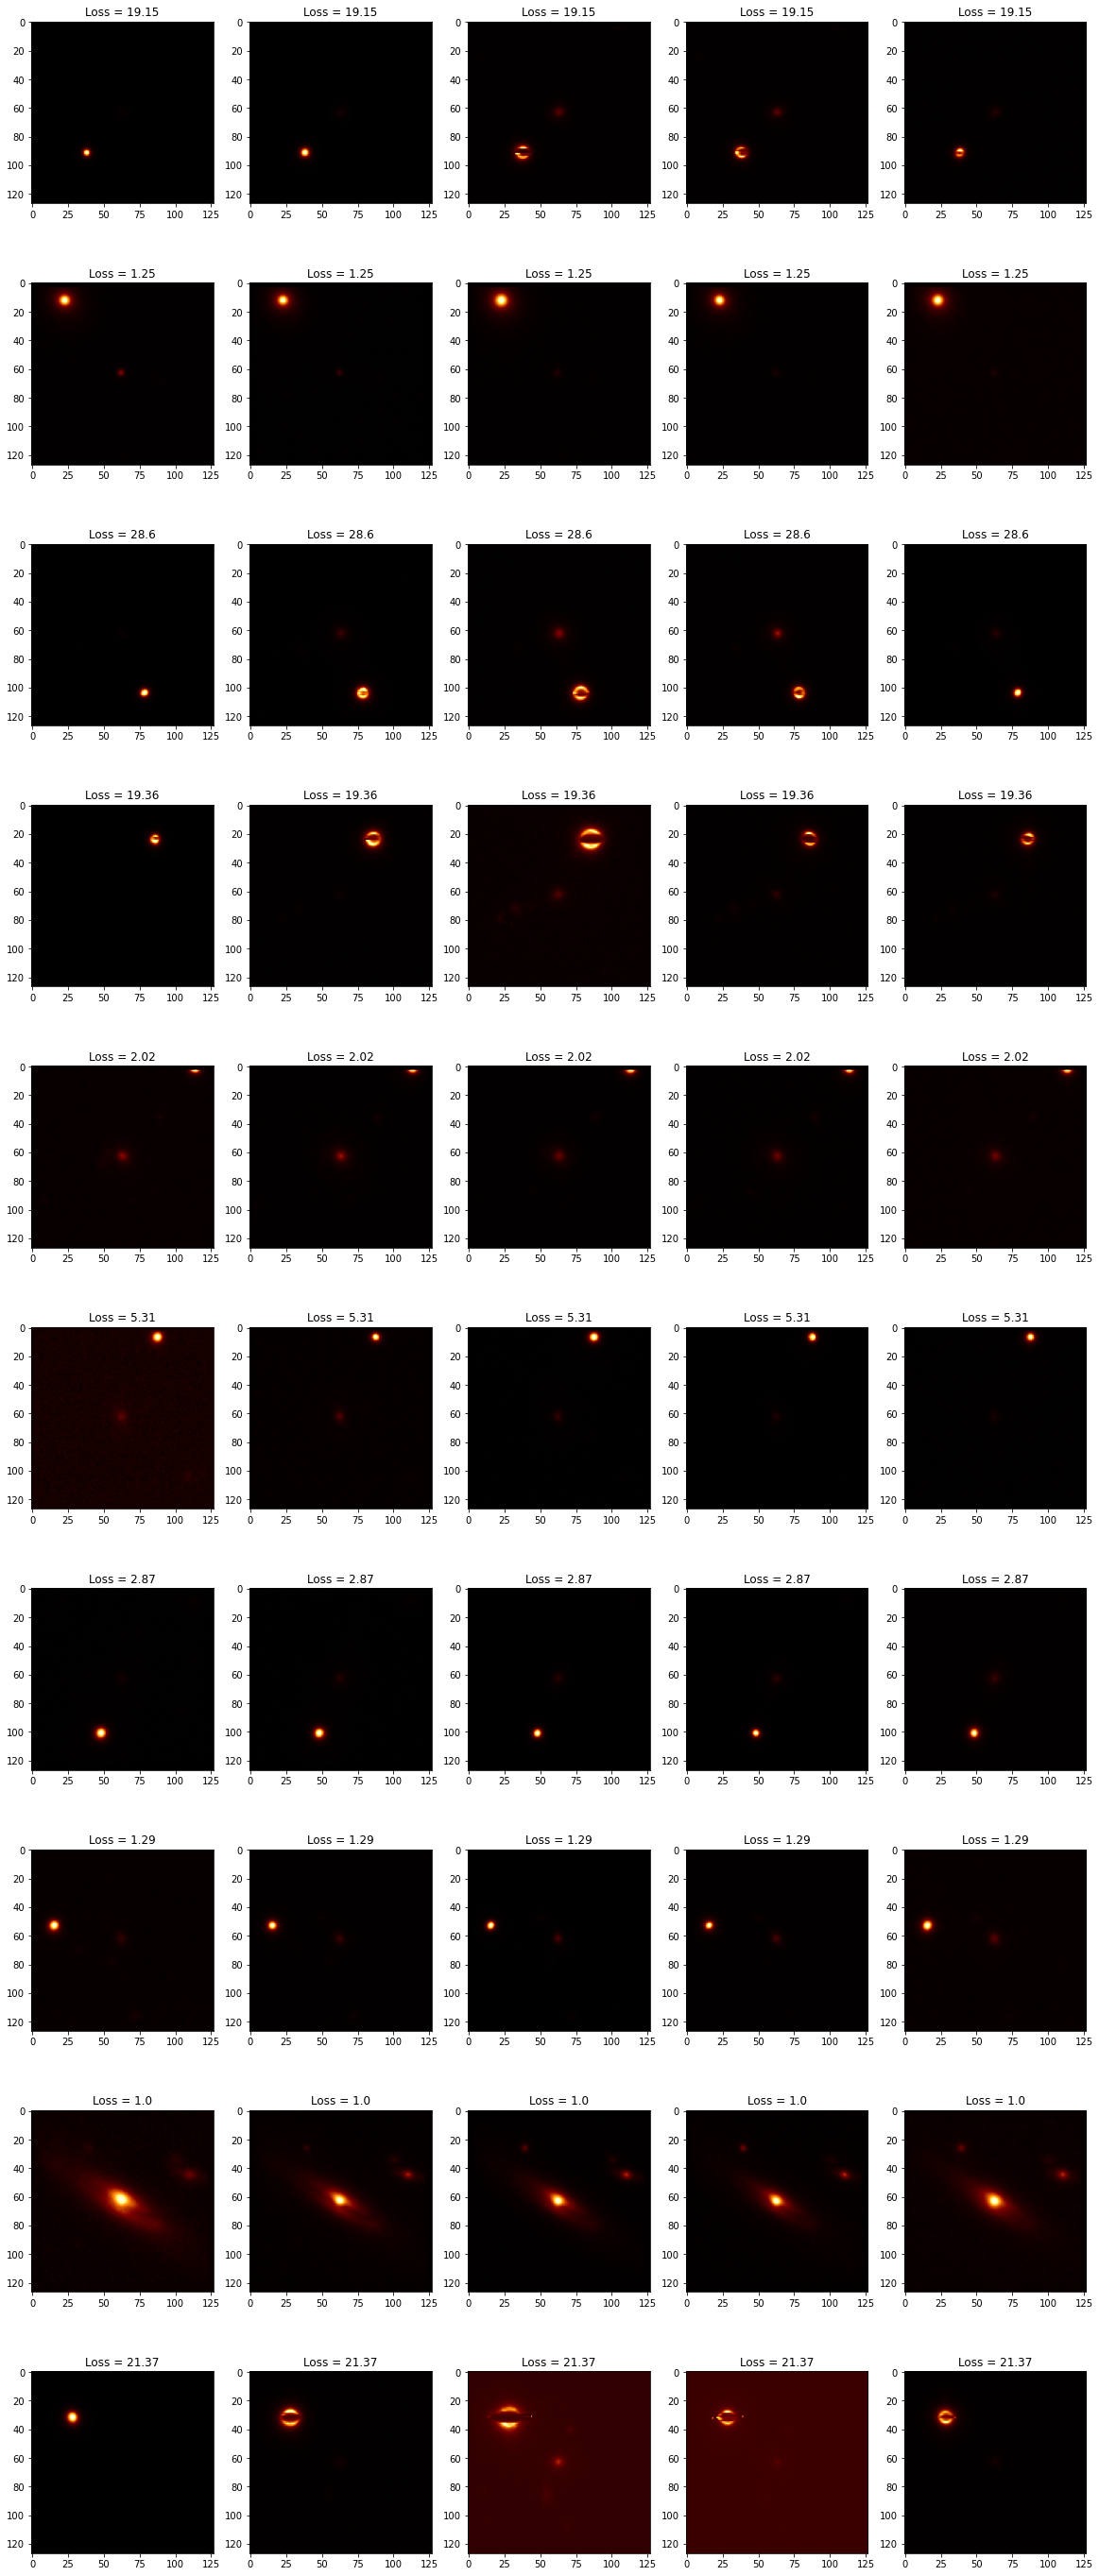

In [45]:
display_high_loss(10, 1)

In [49]:
hf = h5py.File('/mnt/data/HSC/HSC_v6/step3/127x127_generated.hdf5', 'a')
prior1 = tfd.Independent(tfd.Normal(loc=tf.zeros(LATENT_DIM), scale = 0.1), reinterpreted_batch_ndims = 1)
str = prior1.sample(1)[0]
str = np.concatenate((str, np.array([0.1])))
str = str.reshape(1, LATENT_DIM + 1)
image_g = decoder([str])[0][0]
image_r = decoder([str])[0][1]
image_i = decoder([str])[0][2]
image_z = decoder([str])[0][3]
image_y = decoder([str])[0][4]
five_band_image = []
five_band_image.append(image_g)
five_band_image.append(image_r)
five_band_image.append(image_i)
five_band_image.append(image_z)
five_band_image.append(image_y)
five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 127, 127])
hf.create_dataset('image', data = five_band_image_reshape, chunks = True, maxshape = (None, 5, 127, 127))
hf.create_dataset('specz_redshift', data = [0.1], chunks = True, maxshape = (None, ))
for i in range(9999):
    z = random.uniform(0, 4)
    str = prior.sample(1)[0]
    str = np.concatenate((str, np.array([z])))
    str = str.reshape(1, LATENT_DIM + 1)
    image_g = decoder([str])[0][0]
    image_r = decoder([str])[0][1]
    image_i = decoder([str])[0][2]
    image_z = decoder([str])[0][3]
    image_y = decoder([str])[0][4]
    five_band_image = []
    five_band_image.append(image_g)
    five_band_image.append(image_r)
    five_band_image.append(image_i)
    five_band_image.append(image_z)
    five_band_image.append(image_y)
    five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 127, 127])
    hf['specz_redshift'].resize((hf['specz_redshift'].shape[0] + 1), axis = 0)
    hf['specz_redshift'][hf['specz_redshift'].shape[0] - 1] = [z]
    hf['image'].resize((hf['image'].shape[0] + 1), axis = 0)
    hf['image'][hf['image'].shape[0] - 1, :, :, :] = five_band_image
hf.close()

In [ ]:
hf = h5py.File('/mnt/data/HSC/HSC_v6/step3/127x127_generated_test.hdf5', 'a')
str = prior.sample(1)[0]
str = np.concatenate((str, np.array([0.1])))
str = str.reshape(1, LATENT_DIM + 1)
image_g = decoder([str])[0][0]
image_r = decoder([str])[0][1]
image_i = decoder([str])[0][2]
image_z = decoder([str])[0][3]
image_y = decoder([str])[0][4]
five_band_image = []
five_band_image.append(image_g)
five_band_image.append(image_r)
five_band_image.append(image_i)
five_band_image.append(image_z)
five_band_image.append(image_y)
five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 127, 127])
hf.create_dataset('image', data = five_band_image_reshape, chunks = True, maxshape = (None, 5, 127, 127))
hf.create_dataset('specz_redshift', data = [0.1], chunks = True, maxshape = (None, ))
for i in range(1999):
    z = random.uniform(0,4)
    str = prior.sample(1)[0]
    str = np.concatenate((str, np.array([z])))
    str = str.reshape(1, LATENT_DIM + 1)
    image_g = decoder([str])[0][0]
    image_r = decoder([str])[0][1]
    image_i = decoder([str])[0][2]
    image_z = decoder([str])[0][3]
    image_y = decoder([str])[0][4]
    five_band_image = []
    five_band_image.append(image_g)
    five_band_image.append(image_r)
    five_band_image.append(image_i)
    five_band_image.append(image_z)
    five_band_image.append(image_y)
    five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 127, 127])
    hf['specz_redshift'].resize((hf['specz_redshift'].shape[0] + 1), axis = 0)
    hf['specz_redshift'][hf['specz_redshift'].shape[0] - 1] = [z]
    hf['image'].resize((hf['image'].shape[0] + 1), axis = 0)
    hf['image'][hf['image'].shape[0] - 1, :, :, :] = five_band_image
hf.close()

In [ ]:
hf = h5py.File('/mnt/data/HSC/HSC_v6/step3/127x127_generated_validation.hdf5', 'a')
str = prior.sample(1)[0]
str = np.concatenate((str, np.array([0.1])))
str = str.reshape(1, LATENT_DIM + 1)
image_g = decoder([str])[0][0]
image_r = decoder([str])[0][1]
image_i = decoder([str])[0][2]
image_z = decoder([str])[0][3]
image_y = decoder([str])[0][4]
five_band_image = []
five_band_image.append(image_g)
five_band_image.append(image_r)
five_band_image.append(image_i)
five_band_image.append(image_z)
five_band_image.append(image_y)
five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 127, 127])
hf.create_dataset('image', data = five_band_image_reshape, chunks = True, maxshape = (None, 5, 127, 127))
hf.create_dataset('specz_redshift', data = [0.1], chunks = True, maxshape = (None, ))
for i in range(1999):
    z = random.uniform(0,4)
    str = prior.sample(1)[0]
    str = np.concatenate((str, np.array([z])))
    str = str.reshape(1, LATENT_DIM + 1)
    image_g = decoder([str])[0][0]
    image_r = decoder([str])[0][1]
    image_i = decoder([str])[0][2]
    image_z = decoder([str])[0][3]
    image_y = decoder([str])[0][4]
    five_band_image = []
    five_band_image.append(image_g)
    five_band_image.append(image_r)
    five_band_image.append(image_i)
    five_band_image.append(image_z)
    five_band_image.append(image_y)
    five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 127, 127])
    hf['specz_redshift'].resize((hf['specz_redshift'].shape[0] + 1), axis = 0)
    hf['specz_redshift'][hf['specz_redshift'].shape[0] - 1] = [z]
    hf['image'].resize((hf['image'].shape[0] + 1), axis = 0)
    hf['image'][hf['image'].shape[0] - 1, :, :, :] = five_band_image
hf.close()

In [ ]:
# END